In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AffinityPropagation

#plt.style.use('tableau-colorblind10')
sns.set(font_scale=1.3)

In [2]:
folder = 'data_p'
outfile = 'simulation_params_N4new.dat'
maxN = 3001

In [3]:
#Read earnings sequences
earn_data = []
for n in range(0,maxN,5):
    earnings = []
    with open(folder+"/earnings_evol_{0:04d}.dat".format(n), "r") as fdata:
        for line in fdata:
            v = list(map(int,line.split()))
            earnings.append(v[1:])
    earn_data.append(earnings)
earn_data = np.array(earn_data)
earn_data.shape

(601, 2001, 4)

In [4]:
def unorm(row):
    mx = np.abs(row).max()
    N = len(row)
    if mx != 0:
        return np.array([e/(N*mx) for e in row])
    else:
        return row

def nnorm(row):
    N = len(row)
    return np.array([e/N for e in row])

In [5]:
# Scale utility by N
utilities = np.array([[nnorm(e) for e in earnings] for earnings in earn_data])
utilities.shape

(601, 2001, 4)

In [6]:
#Efficiencies
efficiencies = [np.array([u.mean() for u in util]) for util in utilities]
#efficiencies

In [7]:
#Inequalities
inequalities = [np.array([u.std() for u in util]) for util in utilities]
#inequalities

In [8]:
efficiencies = np.array(efficiencies)
inequalities = np.array(inequalities)

In [9]:
def mean_amplitude(arr):
    dif = [np.abs(arr[i+1]-arr[i]) for i in range(len(arr)-1)]
    return np.mean(dif)

def lowest_disper_n(arr, mx_win_sz):
    minamp, minn = 1.e10, 1e10
    for n in range(2,min(len(arr),mx_win_sz)):
        new_arr = []
        for i in range(len(arr)-n):
            new_arr.append(np.mean(arr[i:i+n]))
        amp = mean_amplitude(new_arr)
        if amp < minamp:
            minamp = amp
            minn = n
    return minn

def rolling_avg(arr, mx_win_sz):
    dif = []
    for j in range(0,len(arr)-mx_win_sz):
        minn = lowest_disper_n(arr[j:j+mx_win_sz],mx_win_sz)
        dif.append(np.mean(arr[j:j+minn]))
    return dif

/home/carlos/Documents/Information/edgar_german/el_farol/markov_fplay/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/carlos/Documents/Information/edgar_german/el_farol/markov_fplay/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


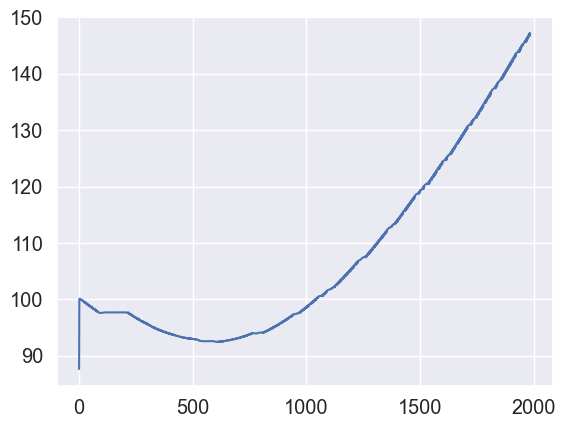

In [10]:
mx_win_sz = 16
n = 345
dif = rolling_avg(inequalities[n], mx_win_sz)

fig, ax = plt.subplots(1,1)
ax.plot(dif)
plt.show()

In [11]:
import pandas as pd
#Read data with kmeans clustering
df = pd.read_csv("tsne_params.csv")
df_ik = df[["index","kmeans"]]

In [12]:
for num, cluster in df_ik.groupby("kmeans"):
    slopes = []
    for n in cluster.index:
        dif = rolling_avg(inequalities[n], mx_win_sz)
        slopes.append((dif[-1]-dif[1])/(len(dif)-1))
    print(np.mean(slopes),np.std(slopes))

/home/carlos/Documents/Information/edgar_german/el_farol/markov_fplay/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/carlos/Documents/Information/edgar_german/el_farol/markov_fplay/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.022784399862661574 0.02636377492036467
0.08198515955474363 0.028185387680704346
0.06578629290785519 0.03109817884401857
0.032944540174855395 0.02555752877828742
0.013282254688647216 0.01511748382506129
0.003599052067448315 0.027676064864474697
-0.0021587620489108227 0.012058456308142592


With 7 clusters it can be seen that the average slope measure for inequality growth coincides fairly well with the clusters.